In [1]:
#import pyrosm
import geopandas as gpd
import pandas as pd
import numpy as np
#import seaborn as sns
#from matplotlib import pyplot as plt
import contextily as cx
import gc
import utils

In [ ]:
# load openstreetmap basemap
# https://www.openstreetmap.org/export - boundingbox setup
bbox = [16.3837, 49.0946, 16.9227, 49.2884]  # [minx, miny, maxx, maxy]
pbf_reader = pyrosm.OSM('datasets/czech_republic-latest.osm.pbf', bounding_box=bbox)
cycling_network = pbf_reader.get_network('cycling')
driving_network = pbf_reader.get_network('driving')
basemap_network = driving_network.append(cycling_network)
del cycling_network
del driving_network
gc.collect()

# load strava data
strava_df = pd.read_csv('datasets/strava_edges_2021.csv')
# load bike-to-work data
biketowork_df = gpd.read_file('datasets/do_prace_na_kole.geojson')
# load mechanical counters data
counters_df = gpd.read_file('datasets/cyklodetektory.geojson')
# load driving census data
census_df = pd.read_excel('datasets/rsd_scitanie_dopravy_2020.xlsx', skiprows=[0])

In [ ]:
# drop unnecessary columns - speedup
strava_df = strava_df.drop([
    'forward_morning_trip_count',
    'reverse_morning_trip_count',
    'forward_evening_trip_count',
    'reverse_evening_trip_count',
    'forward_male_people_count',
    'reverse_male_people_count',
    'forward_female_people_count',
    'reverse_female_people_count',
    'forward_unspecified_people_count',
    'reverse_unspecified_people_count',
    'forward_13_19_people_count',
    'reverse_13_19_people_count',
    'forward_20_34_people_count',
    'reverse_20_34_people_count',
    'forward_35_54_people_count',
    'reverse_35_54_people_count',
    'forward_55_64_people_count',
    'reverse_55_64_people_count',
    'forward_65_plus_people_count',
    'reverse_65_plus_people_count',
    'activity_type',
    'year'
], axis=1)
# drop from counters
counters_df = counters_df.drop([
    'ID',
    'FirstDirection_Name',
    'FirstDirection_Pedestrians',
    'FirstDirection_Total',
    'SecondDirection_Name',
    'SecondDirection_Pedestrians',
    'SecondDirection_Total',
    'LocationId',
    'Latitude',
    'Longitude',
], axis=1)
counters_df

census_df = census_df[census_df['NÁZEV_MĚSTA'] == 'Brno']

In [ ]:
print(basemap_network.shape)
print(strava_df.shape)

## Match strava data to OSM basemap

In [ ]:
# create model from basemap and strava data
model = strava_df.join(basemap_network.set_index('id'), on='osm_reference_id', how='inner')
del basemap_network
del strava_df
gc.collect()
model = model.drop_duplicates()
# https://www.openstreetmap.org/way/{id}
print(model.shape)
model.head()

## Match mechanical counters to basemap

In [ ]:
# load distances between ways and mechanical counter units
counters = counters_df['geometry'].unique()
for i, item in enumerate(counters):
    # within <- exact match fails (needs threshold), better to use distance
    model[f'distance{i}'] = model['geometry'].apply(lambda x: x.distance(item))

counter_units = []
for counter_geo in counters:
    counter_units.append(counters_df[counters_df['geometry']==counter_geo]['UnitName'].unique()[0])

model.head()

In [ ]:
# check if counter street was found (OPTIONAL)
for i in range(len(counters)):
    print(f'Counter #{i}: ({counters_df[counters_df["geometry"]==counters[i]]["UnitName"].unique()[0]})')
    print(f'Lon: {counters[i].x}\nLat: {counters[i].y}')
    print(f'Closest way: {model[model[f"distance{i}"]==model[f"distance{i}"].min()]["osm_reference_id"].values}')

In [ ]:
# draw and save edges matched to counters
#fig = plt.figure(figsize=[20, 20], dpi=800)
#ax = plt.axes()
#fig.add_axes(ax)
unit_way_dict = {}
for i in range(len(counters)):
    min_dist = model[model[f"distance{i}"]==model[f"distance{i}"].min()]
    counter_matches = min_dist['geometry']
    geoser = gpd.GeoSeries(counter_matches)
    #geoser.plot(ax=ax)
    json_str = geoser.to_json()
    unit_way_dict[counter_units[i]] = min_dist['osm_reference_id'].unique()[0]
    #with open(f'counters_matching/counter{i}_matches.geojson', 'w+') as f:
    #    f.write(json_str)
# append edges to counters_df
counters_df['way_id'] = counters_df['UnitName'].map(unit_way_dict)
#counters_df.plot(ax=ax)
#cx.add_basemap(ax, crs=counters_df.crs, zoom=12)
#with open(f'counters_matching/counters.geojson', 'w+') as f:
#    f.write(gpd.GeoSeries(counters).to_json())

for i in range(len(counters)):
    model = model.drop([f'distance{i}'], axis=1)
counters_df.head()

In [ ]:
counters_df.to_file('counters_matched.geojson', driver="GeoJSON")

In [ ]:
# save final model
model.to_csv('model.csv', sep=';')
gpd.GeoDataFrame(model).to_file('model.geojson', driver="GeoJSON")

In [ ]:
model.to_pickle('model.pkl')

### From this point load model from pickle to skip setup

In [2]:
model = pd.read_pickle('model.pkl')

In [3]:
model_shrink = model.drop_duplicates(subset='osm_reference_id')
model_shrink['biketowork_gid'] = np.empty((len(model_shrink), 0)).tolist() # pd.Series([[] for _ in range(len(model_shrink))])
biketowork_df = gpd.read_file('datasets/do_prace_na_kole.geojson')
biketowork_shrink = biketowork_df.drop_duplicates(subset='GID_ROAD')

/tmp/ipykernel_7129/706342565.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_shrink['biketowork_gid'] = np.empty((len(model_shrink), 0)).tolist() # pd.Series([[] for _ in range(len(model_shrink))])


## Match model OSM basemap to biketowork ways
### (brute force N:N matching - VERY SLOW)

In [ ]:
for index, row in biketowork_df.iterrows():
    model_shrink['biketowork_gid'] = model_shrink.apply(lambda x: utils.assign_overlap(row, x['geometry'], x['biketowork_gid'], row['GID_ROAD']),
                                                        axis=1,)

In [ ]:
# osm=94635449 gid=224682
# osm=5606151 gid=224865  # NERUDOVA
# osm=8134289 gid=[224865.0]
# osm=33265238 gid=[224868.0]
model_shrink.to_csv('model_with_dpnk.csv', sep=';')
gpd.GeoDataFrame(model_shrink).to_file('model_with_dpnk.geojson', driver="GeoJSON")
model_shrink[['biketowork_gid', 'osm_reference_id']]

## Create map segment matrix

In [4]:
from itertools import pairwise

def generate_segments(bbox, num_of_segments):
    # X Segments
    degree_width = bbox[2] - bbox[0]
    segment_width = degree_width / num_of_segments
    start_minx = bbox[0]
    segment_mins_x = [start_minx + (segment_width*n) for n in range(NUM_OF_SEGMENTS+1)]
    # Y segments
    degree_height = bbox[3] - bbox[1]
    segment_heigth = degree_height / num_of_segments
    start_miny = bbox[1]
    segment_mins_y = [start_miny + (segment_heigth*n) for n in range(NUM_OF_SEGMENTS+1)]

    # create segment matrix
    segments_matrix = []
    y_pairs = pairwise(segment_mins_y)
    for y_limits in y_pairs:
        x_pairs = pairwise(segment_mins_x)
        for x_limits in x_pairs:
            segments_matrix.append((x_limits[0], y_limits[0], x_limits[1], y_limits[1]))

    return segments_matrix

bbox = (16.3837, 49.0946, 16.9227, 49.2884)  # [minx, miny, maxx, maxy]
NUM_OF_SEGMENTS = 20
segments_matrix = generate_segments(bbox, NUM_OF_SEGMENTS)

## Match model street to segment

In [5]:
def is_in_segment(row_bbox, segment):
    # check if falls fully into the segment (leaves streets that break segment borders)
    if row_bbox[0] < segment[0]:  # min X
        return False
    if row_bbox[1] < segment[1]:  # min Y
        return False
    if row_bbox[2] > segment[2]:  # max X
        return False
    if row_bbox[3] > segment[3]:  # max Y
        return False
    # print(f"segment: {segment}\nrow: {row_bbox}")
    return True


def alternative_is_in_segment(row_bbox, segment):
    # check if start of the street lays in the segment
    if (row_bbox[0] > segment[0]) and \
       (row_bbox[0] < segment[2]) and \
       (row_bbox[1] > segment[1]) and \
       (row_bbox[1] < segment[3]):
        return True
    else:
        return False


def assign_segments_to_dataset(dataset, segment_matrix, id_column):
    segment_ids = []
    street_ids = []
    for _, row in dataset.iterrows():
        row_bbox = row['geometry'].bounds
        # check every segment
        for index, segment in enumerate(segment_matrix):
            # save found segment and street ID
            if alternative_is_in_segment(row_bbox, segment):
                segment_ids.append(index)
                street_ids.append(row[id_column])
                break

    street_to_segment_df = pd.DataFrame({ id_column: street_ids, 'segment_id': segment_ids})
    return dataset.merge(street_to_segment_df, on=id_column)

model_shrink = assign_segments_to_dataset(model_shrink, segments_matrix, 'osm_reference_id')
biketowork_shrink = assign_segments_to_dataset(biketowork_shrink, segments_matrix, 'GID_ROAD')

In [6]:
model_shrink['segment_id'].value_counts()
biketowork_shrink['segment_id'].value_counts()

230    1236
188    1228
208    1202
267    1158
247    1157
       ... 
356       1
37        1
3         1
22        1
297       1
Name: segment_id, Length: 392, dtype: int64

<AxesSubplot: >

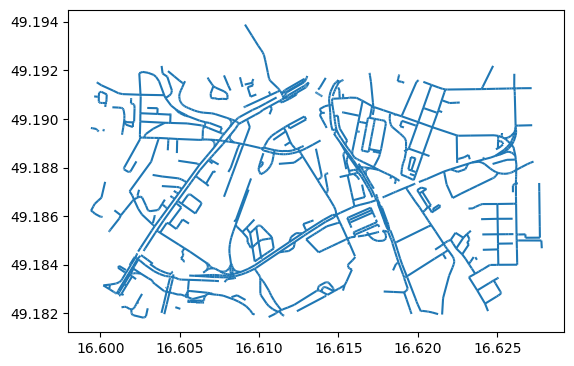

In [12]:
gpd.GeoDataFrame(model_shrink[model_shrink['segment_id'] == 188]).plot()

<AxesSubplot: >

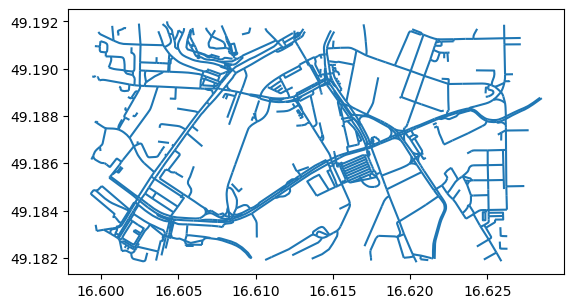

In [13]:
gpd.GeoDataFrame(biketowork_shrink[biketowork_shrink['segment_id'] == 188]).plot()

In [9]:
# try street matching per segment
for segm_id in range(len(segments_matrix)):
    model_segm = model_shrink[model_shrink['segment_id'] == segm_id].copy()
    model_segm['biketowork_gid'] = np.empty((len(model_segm), 0)).tolist()
    for index, row in biketowork_shrink[biketowork_shrink['segment_id'] == segm_id].iterrows():
        model_segm['biketowork_gid'] = model_segm.apply(lambda x: utils.assign_overlap(row, x['geometry'], x['biketowork_gid'], row['GID_ROAD']), axis=1,)
# TODO: not working ATM


ValueError: Columns must be same length as key

## Try line matching with segments and angle calculations

In [25]:
model_tmp = pd.read_pickle('model_shrink_segmented.pkl')
biketowork_tmp = pd.read_pickle('biketowork_shrink_segmented.pkl')
model_160 = model_tmp[model_tmp['segment_id'] == 160].copy()
biketowork_160 = biketowork_tmp[biketowork_tmp['segment_id'] == 160].copy()

matched_lines = []
for line_real in model_160['geometry']:
    new_match = utils.match_lines(line_real, biketowork_160['geometry'])
    if new_match:
        new_gid = biketowork_160[biketowork_160['geometry'] == new_match]['GID_ROAD'].array[0]
    else:
        new_gid = np.NaN
    matched_lines.append(new_gid)

model_160['GID_ROAD'] = matched_lines

In [14]:
model_160['GID_ROAD'].value_counts()
model_160.head()

,edge_uid,forward_trip_count,reverse_trip_count,forward_people_count,reverse_people_count,forward_commute_trip_count,reverse_commute_trip_count,forward_leisure_trip_count,reverse_leisure_trip_count,forward_average_speed,...,timestamp,version,tags,osm_type,geometry,length,path,biketowork_gid,segment_id,GID_ROAD
402,161016962,85,150,35,50,5,10,80,140,3.80,...,1448129496,1,None,way,"MULTILINESTRING ((16.38488 49.18433, 16.38475 ...",372.0,None,[],160,220460.0
1331,161016953,250,270,35,25,30,40,220,230,7.72,...,1472334589,7,"{""source:maxspeed"":""sign""}",way,"MULTILINESTRING ((16.39205 49.18054, 16.39194 ...",236.0,NaN,[],160,155486.0
2072,161017586,35,10,10,5,5,0,30,10,5.10,...,1305378966,4,None,way,"MULTILINESTRING ((16.39231 49.18022, 16.39255 ...",379.0,NaN,[],160,19673.0
2211,161016895,45,20,30,20,0,0,45,20,3.14,...,1472334573,1,None,way,"MULTILINESTRING ((16.38854 49.17636, 16.38858 ...",9.0,NaN,[],160,19980.0
2333,161017725,775,895,245,290,75,100,700,795,3.79,...,1660409119,10,"{""source:maxspeed"":""CZ:urban"",""source:ref"":""rs...",way,"MULTILINESTRING ((16.39844 49.17843, 16.39848 ...",521.0,NaN,[],160,221300.0


In [29]:
joined_model160 = model_160.merge(biketowork_160, on='GID_ROAD', how='left')
joined_model160.head()

,edge_uid,forward_trip_count,reverse_trip_count,forward_people_count,reverse_people_count,forward_commute_trip_count,reverse_commute_trip_count,forward_leisure_trip_count,reverse_leisure_trip_count,forward_average_speed,...,OBJECTID,COUNT_LINE,data_2018,data_2019,data_2020,data_2021,GlobalID,SHAPE_Length,geometry_y,segment_id_y
0,161016962,85,150,35,50,5,10,80,140,3.80,...,42280.0,11.0,1.0,1.0,1.0,8.0,{3BF03D5C-8771-41D3-A7BB-94FB36178768},0.000178,"MULTILINESTRING ((16.38621 49.18077, 16.38627 ...",160.0
1,161016953,250,270,35,25,30,40,220,230,7.72,...,18193.0,19.0,3.0,5.0,3.0,7.0,{058698DA-0484-48F9-A834-19B15EE62774},0.001327,"MULTILINESTRING ((16.39146 49.17956, 16.39157 ...",160.0
2,161017586,35,10,10,5,5,0,30,10,5.10,...,4520.0,2.0,1.0,1.0,1.0,0.0,{53D73E7E-DC73-4BFA-B85A-47AE00A65671},0.001321,"MULTILINESTRING ((16.39734 49.17988, 16.39603 ...",160.0
3,161016895,45,20,30,20,0,0,45,20,3.14,...,4541.0,2.0,1.0,1.0,1.0,0.0,{8540FC46-227D-42E4-86E4-69F6502BEA37},0.001197,"MULTILINESTRING ((16.38856 49.17639, 16.38846 ...",160.0
4,161017725,775,895,245,290,75,100,700,795,3.79,...,42954.0,67.0,15.0,24.0,15.0,13.0,{18D24117-61D7-4D18-9729-1B86333E3E32},0.000485,"MULTILINESTRING ((16.39860 49.17958, 16.39854 ...",160.0


In [39]:
#joined_model160 = joined_model160.drop('biketowork_gid', axis=1)
joined_model160.head()
#joined_model160 = joined_model160.drop('geometry_y', axis=1)
joined_model160 = joined_model160.rename(columns={"geometry_x": 'geometry'})
gpd.GeoDataFrame(joined_model160).to_file('model_160_matched_biketowork.geojson', driver="GeoJSON")
